## Reducing Network Latency & Anomaly Detecting using LSTM Autoencoders

The goal of this project is twofold:
- Reduce the network traffic in the cloud from the gateway layer.
- Detect anomalous data, indicating a faulty sensor or a potential attack.

We use a subset of data collected from Intel Labs between March and April, 2004 (http://db.csail.mit.edu/labdata/labdata.htmlO) as a proof of concept for applying Deep Learning at the IoT Gateway Layer.

In the best case scenario, we can send predicted batches of time series data that are representative of the actual readings in $n/k$ transmissions, where $n$ is the size of our time series set, and $k$ is the batching size.

In the worst case scenario, incorrectly predicted batch values will update what is currently in the cloud at the time of sensor reading. This scenario will perform as well as trivially passing data from the gateway to the cloud unhindered in $n$ transmissions.

### Data Loading

In [1]:
import gzip
import pandas as pd

In [2]:
with gzip.open('data.txt.gz', 'rb') as data_bytes:
    data = pd.read_csv(data_bytes, header=None, sep=' ', parse_dates=[[0, 1]], squeeze=True)
data.columns = ['DATETIME','EPOCH','SENSOR_ID','TEMPERATURE','HUMIDITY','LIGHT','VOLTAGE']
data = data.set_index('DATETIME')

In [3]:
data.shape

(2313682, 6)

### Data Pre-processing

We will consider sensor data between March 1st and March 10th for this experiment, as it contains the majority of the complete data.

In [35]:
data_samp = data.loc['2004-03-01':'2004-03-10'].copy()
data_samp.shape

(892574, 6)

For the purposes of a proof of concept, we will make this a univariate problem (not including DateTime), focusing on Temperature readings.

In [36]:
data_samp.drop(['HUMIDITY','LIGHT','VOLTAGE','EPOCH'], axis=1, inplace=True)

Dropping any Sensor ID's where the value is NaN.

In [37]:
data_samp.dropna(subset=['SENSOR_ID'], inplace=True)

For the sake of out experiment, let us only consider sensors 1-10.

In [38]:
data_samp = data_samp[(data_samp.SENSOR_ID >= 1) & (data_samp.SENSOR_ID <= 10)]

Reshaping the Sensor ID field to an integer value.

In [39]:
data_samp.SENSOR_ID.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [40]:
data_samp.SENSOR_ID = data_samp.SENSOR_ID.astype(int)
data_samp.dtypes

SENSOR_ID        int64
TEMPERATURE    float64
dtype: object

In [41]:
data_samp.head()

,SENSOR_ID,TEMPERATURE
DATETIME,,
2004-03-01 00:01:57.130850,1,18.4498
2004-03-01 00:02:50.458234,1,18.4400
2004-03-01 00:04:26.606602,1,18.4400
2004-03-01 00:05:28.379208,1,18.4498
2004-03-01 00:05:50.456126,1,18.4302


We want to measure the temperature at each sensor for a given timestamp, so we will pivot the table, making the column values sensor temperature readings at a given timestamp.

In [42]:
data_samp = data_samp.pivot(columns='SENSOR_ID', values='TEMPERATURE')

In [43]:
data_samp.head()

SENSOR_ID,1,2,3,4,5,6,7,8,9,10
DATETIME,,,,,,,,,,
2004-03-01 00:00:21.445722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.489,NaN
2004-03-01 00:00:22.429139,NaN,18.8712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01 00:00:25.633782,NaN,NaN,NaN,NaN,NaN,NaN,18.7144,NaN,NaN,NaN
2004-03-01 00:00:52.381230,NaN,18.8614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01 00:00:53.317719,NaN,NaN,NaN,NaN,NaN,NaN,18.7046,NaN,NaN,NaN


There appears to be a lot of missing values for temperature readings in our table, due to micro-second DateTime ID's in our time series set. We will resample the data every 2 minutes, taking the mean of the values collected.

In [44]:
data_samp = data_samp.resample('2min').mean()

In [45]:
print('New resampled set has: {} data points.'.format(len(data_samp)))
data_samp.isna().sum()

New resampled set has: 6754 data points.


SENSOR_ID
1      143
2      629
3      114
4      349
5     6754
6      582
7       17
8      753
9       65
10     163
dtype: int64

Clearly sensor 5 is not reading values between our time frame, so we will drop it. Stack brings the prescribed column (SENSOR_ID) into our index, making it easily dropped. We unstack to bring Sensor ID out of the index.

In [52]:
temp_df = data_samp.stack().drop(5, level='SENSOR_ID')
data_samp = temp_df.unstack()

In [53]:
data_samp

SENSOR_ID,1,2,3,4,6,7,8,9,10
DATETIME,,,,,,,,,
2004-03-01 00:00:00,18.449800,18.864667,18.753600,19.11130,18.6752,18.70705,18.386100,18.484100,18.430200
2004-03-01 00:02:00,18.440000,18.848333,18.756867,19.10640,18.6654,18.69235,18.378750,18.469400,NaN
2004-03-01 00:04:00,18.440000,18.832000,18.734000,19.10640,18.6654,18.68500,18.376300,18.475933,18.400800
2004-03-01 00:06:00,NaN,18.851600,18.753600,19.10640,18.6654,18.67765,18.377933,18.482467,18.410600
2004-03-01 00:08:00,18.435100,18.861400,18.773200,19.10150,18.6556,18.68500,18.371400,18.479200,18.433467
...,...,...,...,...,...,...,...,...,...
2004-03-10 08:58:00,22.835300,23.178300,23.776100,23.93045,24.0946,23.99170,25.296733,26.044800,24.473533
2004-03-10 09:00:00,22.879400,23.134200,23.717300,23.92800,24.1044,23.92800,25.395550,26.113400,24.589500
2004-03-10 09:02:00,22.869600,23.121950,23.676467,23.90840,24.1485,23.95740,25.496000,26.280000,24.692400


There are still some missing values, which we can simply deal with by applying linear interpolation to estimate values making our set continuous. Interpolation uses previous values, so for values appearing at the front of our frame (ie. sensor 1) we must make the process bidirectional.

In [54]:
data_samp = data_samp.interpolate(method='linear', limit_direction='both', axis=0)

In [57]:
data_samp.isna().sum()

SENSOR_ID
1     0
2     0
3     0
4     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

In [78]:
data_samp.describe()

SENSOR_ID,1,2,3,4,6,7,8,9,10
count,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000,6754.000000
mean,22.192462,22.126009,22.240772,22.249970,21.786615,21.844309,21.621812,21.801295,21.549061
std,2.395218,1.944178,2.198261,2.049267,1.874288,1.955498,2.174163,2.258517,1.976967
min,17.195400,17.642933,17.577600,18.038200,17.616800,17.789933,10.487300,17.499200,17.548200
25%,20.581300,20.881425,20.767500,20.988000,20.547612,20.574563,20.090075,20.143362,20.174600
50%,22.041500,22.259142,22.213000,22.046400,21.821000,21.742600,21.715650,21.811200,21.613567
75%,23.869200,23.349800,23.709133,23.437387,23.166867,23.178300,22.908800,23.152983,22.813250
max,28.654867,27.416800,28.243267,27.652000,26.534800,26.420467,26.453950,27.162000,25.819400


Now our data set smoothly tracks Temperature over a 2 minute interval without undefined data points. Let's plot our findings for each sensor in our dataframe.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x140b7d890>,
      dtype=object)

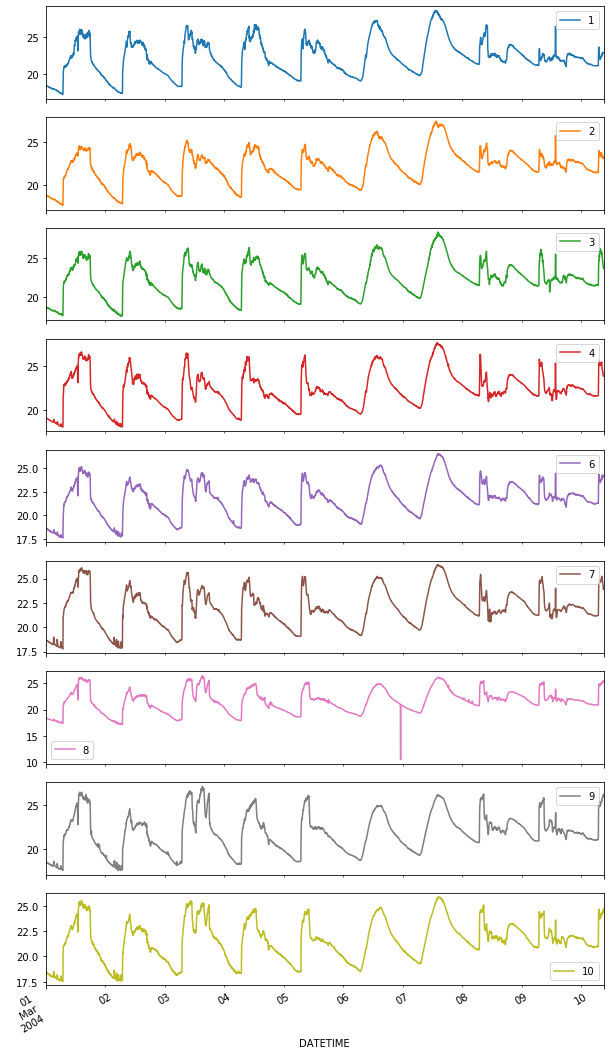

In [77]:
import matplotlib.pyplot as plt

data_samp.plot(subplots=True, legend=True, figsize=(10,20))

### Data Splitting

Given a clean time series set, we can now split our data to train our autoencoder.

In [ ]:
train_size = int(len(sensor_df) * 0.7)
test_size = len(sensor_df) - train_size
train, test = sensor_df.iloc[0:train_size], sensor_df.iloc[train_size:len(sensor_df)]
print(train.shape, test.shape)

In [ ]:
#input_layer = Input(shape=(4,))
# "encoded" is the encoded representation of the input
#encoded = Dense(1, activation='relu')(input_layer)
# "decoded" is the lossy reconstruction of the input
#decoded = Dense(4, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
#autoencoder = Model(input_layer, decoded)

In [ ]:
# autoencoder.summary()